<a href="https://colab.research.google.com/github/ISE-CS4445-AI/challenge-6-Elle0-0/blob/main/challenge-6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge #6: Reducing Overfitting with Regularization (FashionMNIST)

**Instructions**:
- This challenge builds on **Week 6**’s regularization lessons: **data augmentation**, **dropout**, and **weight decay**.
- We demonstrate a baseline CNN on **FashionMNIST** that clearly overfits. Then we apply these techniques to see the improvement.

**Scoring**:  9 points total. Fill in the `# TODO` placeholders and fill in the final reflection markdown cell. **There is no autograder** for this assignment. If your code works without errors and achieves the objectives of reducing overfitting by the end of this challenge, you will have done well. 👍

We’ll use the **FashionMNIST** dataset, which consists of 60,000 training images and 10,000 test images of 28x28 grayscale images of 10 different fashion categories. By applying these techniques, we aim to reduce overfitting and improve robust performance.

---

## Imports & Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print("Torch version:", torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Torch version: 2.5.1+cu124
Using device: cuda


### Utility functions

Defining the utility function to plot metrics below.

In [3]:
'''
Description:
Utility function to plot line plots in a single graph

Params:
dataDict: List - A list of tuples containing the data to be plotted and corresponding plot params as a dictionary (optional).
           Expected key names in paramDict:
           -> label: str - String label to be given to the plot.
                           Only necessary if the 'legend' function param is set to True (False by default).
           -> ha: str - Specifies the horizontal alignment ('left', 'right' or 'center') of text above each point in the plot.
           -> fontsize: int - Sets the font size of text displayed above each point in the plot.
           -> marker: str - Sets the style of marker to be displayed for each data point on the plot. Set to 'o' by default.
           -> decimalPlaces: int - Sets the number of decimal places to display for each data point.
           -> displayPercent: bool - Boolean to decide whether to display numbers in percentage format.
           -> displayOffset: float - positive or negative float value that determines the display offset of text above data point.
title: str - [optional] Title to be set for the graph.
xlabel: str - [optional] Label for the x-axis to be set for the graph.
ylabel: str - [optional] Label for the y-axis to be set for the graph.
figSize: Tuple - [optional] Sets a custom figure size for the plot based on the width and height values passed as a tuple pair.
legend: bool - [optional] Boolean to decide whether to show the legend or not. Set to False by default
'''
def plotMetrics(dataList, X, title='', xlabel='', ylabel='', figSize=None, legend=False):
    if figSize:
            plt.figure(figsize=(figSize))
    for data in dataList:
        y, paramDict = data
        # Getting plot params
        label = paramDict['label'] if 'label' in paramDict else ''
        marker = paramDict['marker'] if 'marker' in paramDict else 'o'
        ha = paramDict['ha'] if 'ha' in paramDict else 'center'
        fontSize = paramDict['fontSize'] if 'fontSize' in paramDict else 8
        decimalPlaces = paramDict['decimalPlaces'] if 'decimalPlaces' in paramDict else 2
        displayPercent = paramDict['displayPercent'] if 'displayPercent' in paramDict else False
        displayOffset = paramDict['displayOffset'] if 'displayOffset' in paramDict else 0.005

        plt.plot(X, y, label=label, marker=marker)

        # Getting the data values to show on the plotted points along the line
        for i, v in enumerate(y):
            percentMultiplier = 100 if displayPercent else 1
            v_str = f'{v * percentMultiplier:.{decimalPlaces}f}{"%" if displayPercent else ""}'
            plt.text(i + 1, v + displayOffset, v_str, ha=ha, fontsize=fontSize)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend:
        plt.legend()
    plt.show()

## Task 1: getTransforms(augmentation=False) <font color='green'>(1 point)</font>

**Goal**: Return a **train_transform** and a **test_transform**.  
- If `augmentation=True`, apply random transformations. Otherwise just basic.  
- *FashionMNIST* is 28×28 grayscale, so consider **random horizontal flip** or **random rotation**. Keep it simple.

In [6]:
def getTransforms(augmentation=False):
    # mean,std for FashionMNIST (approx)
    mean = (0.2860,)
    std = (0.3530,)

    # TODO: define the transformation for the test set (without any data augmentation)
    # test_transform =
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # if augmentation:
        # TODO: define the transformation for the train set (with data augmentation)
        # train_transform =
        # return train_transform, test_transform

    # return test_transform, test_transform
    if augmentation:
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        return train_transform, test_transform

    return test_transform, test_transform


## Task 2: create the dataloaders <font color='green'>(1 point)</font>

In [8]:
def load_fashionMNIST_data(batch_size=64, augmentation=False):
    """
    return train_loader, test_loader
    """

    train_transform, test_transform = getTransforms(augmentation)

    # TODO: download the FashionMNIST dataset
    # train_dataset = torchvision.datasets.FashionMNIST(root='./data', download=True, ...)
    # test_dataset  = torchvision.datasets.FashionMNIST(root='./data', download=True, ...)
    train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
    test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

    # TODO: create the data loaders
    # train_loader =
    # test_loader  =

    # return train_loader, test_loader

    # Create DataLoaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = load_fashionMNIST_data(batch_size=64)
print("Train set size:", len(train_loader.dataset))
print("Test set size:", len(test_loader.dataset))

Train set size: 60000
Test set size: 10000


## Task 3: Define a CNN with Dropout  <font color='green'>(2 points)</font>

**Task**:  
- Build a small **CNN** with a few convolution layers, each followed by ReLU & maxpool.  
- Insert **dropout** layers (e.g., `nn.Dropout(0.3)`) to help reduce overfitting.  
- The final linear outputs 10 classes.  
- We'll call it `NetFashion`.

In [9]:
class NetFashion(nn.Module):
    def __init__(self, dropout_prob=0.3, useRegularization=False):
        super().__init__()
        self.useRegularization = useRegularization
        # TODO: Build a sample CNN architecture (refer architecture from week 6 exercise notebook if needed)
        # Note that the FashionMNIST dataset has 10 classes, input size of 28x28 and 1 channel (greyscale)
        # self.conv1 =
        # self.conv2 =
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2,2) # Remember that a kernel size and stride of 2 each effectively halves the size of the image!

        if self.useRegularization:
            # self.dropout =
            self.dropout = nn.Dropout(dropout_prob)
            pass # remove after completing code above

        # self.conv3 =
        # self.conv4 =
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        # self.fc1 =   # size of image after two pools i.e., 28x28 => ? => ?
        # self.fc2 =
        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)


    def forward(self, x):
        # shape x: (batch,3,32,32)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # (batch,64,16,16)

        # Use regularisation layers as you see fit

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))

        out = self.fc2(x)
        return out

## Training Loop

Below is a standard training loop with helper train and test methods defined which should look familiar by now. :)

In [10]:
def train(dataloader, model, loss_fn, optimiser):
    size = len(dataloader.dataset)
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimiser.zero_grad()

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # This is the backprop set up. Explain what each of the steps do
        loss.backward()
        optimiser.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimiser, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Iterate over each epoch
    for t in tqdm(range(epochs), desc="Epochs"):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimiser)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        # Store and return the losses and accuracies. We can graph these later
        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy

## Task 4: Evaluate & Check Test Accuracy

**Task**:  
1. Measure train and test metrics for non-regularised model with non-augmented data.  
2. Do the same train and test loop for your regularised model on augmented data with weight decay in the optimiser and observe the difference.
   1. However, apply all the different techniques individually.
   2. Run the code cells to plot metrics after each experiment

### Task 4.1: Non-regularised model with non-augmented data  <font color='green'>(1 point)</font>

In [11]:
model = NetFashion().to(device) # Getting the Fashion MNIST model

# TODO: Define the loss function and the optimiser
# loss_fn =
# optimiser =
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)

In [13]:
epochs = 10
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 0.043995  [   64/60000]
loss: 0.038422  [ 6464/60000]
loss: 0.084648  [12864/60000]
loss: 0.045207  [19264/60000]
loss: 0.105721  [25664/60000]
loss: 0.056005  [32064/60000]
loss: 0.072878  [38464/60000]
loss: 0.156709  [44864/60000]
loss: 0.080907  [51264/60000]
loss: 0.050918  [57664/60000]


Epochs:  10%|█         | 1/10 [00:32<04:54, 32.67s/it]

Train Error: 
 Accuracy: 97.6%, Avg loss: 0.064073 

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.254087 

Epoch 2:

loss: 0.101711  [   64/60000]
loss: 0.002378  [ 6464/60000]
loss: 0.125668  [12864/60000]
loss: 0.035593  [19264/60000]
loss: 0.036049  [25664/60000]
loss: 0.133135  [32064/60000]
loss: 0.074186  [38464/60000]
loss: 0.075560  [44864/60000]
loss: 0.173177  [51264/60000]
loss: 0.057151  [57664/60000]


Epochs:  20%|██        | 2/10 [01:03<04:13, 31.63s/it]

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.043481 

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.271540 

Epoch 3:

loss: 0.035549  [   64/60000]
loss: 0.028595  [ 6464/60000]
loss: 0.026661  [12864/60000]
loss: 0.038812  [19264/60000]
loss: 0.138358  [25664/60000]
loss: 0.089323  [32064/60000]
loss: 0.024297  [38464/60000]
loss: 0.041083  [44864/60000]
loss: 0.089284  [51264/60000]
loss: 0.022186  [57664/60000]


Epochs:  30%|███       | 3/10 [01:35<03:41, 31.62s/it]

Train Error: 
 Accuracy: 98.6%, Avg loss: 0.038464 

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.322018 

Epoch 4:

loss: 0.003480  [   64/60000]
loss: 0.000943  [ 6464/60000]
loss: 0.052655  [12864/60000]
loss: 0.034207  [19264/60000]
loss: 0.051593  [25664/60000]
loss: 0.018994  [32064/60000]
loss: 0.085045  [38464/60000]
loss: 0.056465  [44864/60000]
loss: 0.048676  [51264/60000]
loss: 0.029274  [57664/60000]


Epochs:  40%|████      | 4/10 [02:06<03:08, 31.49s/it]

Train Error: 
 Accuracy: 99.2%, Avg loss: 0.024189 

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.341182 

Epoch 5:

loss: 0.006708  [   64/60000]
loss: 0.014028  [ 6464/60000]
loss: 0.016864  [12864/60000]
loss: 0.045211  [19264/60000]
loss: 0.006390  [25664/60000]
loss: 0.105884  [32064/60000]
loss: 0.048103  [38464/60000]
loss: 0.041000  [44864/60000]
loss: 0.034801  [51264/60000]
loss: 0.007912  [57664/60000]


Epochs:  50%|█████     | 5/10 [02:37<02:37, 31.49s/it]

Train Error: 
 Accuracy: 99.3%, Avg loss: 0.021331 

Test Error: 
 Accuracy: 92.9%, Avg loss: 0.323929 

Epoch 6:

loss: 0.013422  [   64/60000]
loss: 0.011883  [ 6464/60000]
loss: 0.080735  [12864/60000]
loss: 0.013790  [19264/60000]
loss: 0.086264  [25664/60000]
loss: 0.018829  [32064/60000]
loss: 0.043881  [38464/60000]
loss: 0.022509  [44864/60000]
loss: 0.012354  [51264/60000]
loss: 0.035413  [57664/60000]


Epochs:  60%|██████    | 6/10 [03:09<02:06, 31.61s/it]

Train Error: 
 Accuracy: 99.4%, Avg loss: 0.018091 

Test Error: 
 Accuracy: 92.8%, Avg loss: 0.375564 

Epoch 7:

loss: 0.013579  [   64/60000]
loss: 0.019512  [ 6464/60000]
loss: 0.067997  [12864/60000]
loss: 0.000535  [19264/60000]
loss: 0.006548  [25664/60000]
loss: 0.006292  [32064/60000]
loss: 0.008084  [38464/60000]
loss: 0.020442  [44864/60000]
loss: 0.007509  [51264/60000]
loss: 0.032769  [57664/60000]


Epochs:  70%|███████   | 7/10 [03:40<01:34, 31.45s/it]

Train Error: 
 Accuracy: 98.9%, Avg loss: 0.031936 

Test Error: 
 Accuracy: 92.1%, Avg loss: 0.390609 

Epoch 8:

loss: 0.002787  [   64/60000]
loss: 0.004851  [ 6464/60000]
loss: 0.012478  [12864/60000]
loss: 0.013910  [19264/60000]
loss: 0.000521  [25664/60000]
loss: 0.029859  [32064/60000]
loss: 0.006736  [38464/60000]
loss: 0.018147  [44864/60000]
loss: 0.020616  [51264/60000]
loss: 0.052265  [57664/60000]


Epochs:  80%|████████  | 8/10 [04:12<01:03, 31.58s/it]

Train Error: 
 Accuracy: 99.4%, Avg loss: 0.016181 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.423165 

Epoch 9:

loss: 0.051036  [   64/60000]
loss: 0.001109  [ 6464/60000]
loss: 0.083751  [12864/60000]
loss: 0.013505  [19264/60000]
loss: 0.008581  [25664/60000]
loss: 0.011930  [32064/60000]
loss: 0.005045  [38464/60000]
loss: 0.003516  [44864/60000]
loss: 0.095447  [51264/60000]
loss: 0.043380  [57664/60000]


Epochs:  90%|█████████ | 9/10 [04:47<00:32, 32.61s/it]

Train Error: 
 Accuracy: 99.4%, Avg loss: 0.018898 

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.476750 

Epoch 10:

loss: 0.015137  [   64/60000]
loss: 0.000155  [ 6464/60000]
loss: 0.008631  [12864/60000]
loss: 0.006142  [19264/60000]
loss: 0.002155  [25664/60000]
loss: 0.098966  [32064/60000]
loss: 0.023147  [38464/60000]
loss: 0.041567  [44864/60000]
loss: 0.046726  [51264/60000]
loss: 0.004095  [57664/60000]


Epochs: 100%|██████████| 10/10 [05:21<00:00, 32.11s/it]

Train Error: 
 Accuracy: 99.4%, Avg loss: 0.016965 

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.462123 

Done training!


Plotting metrics

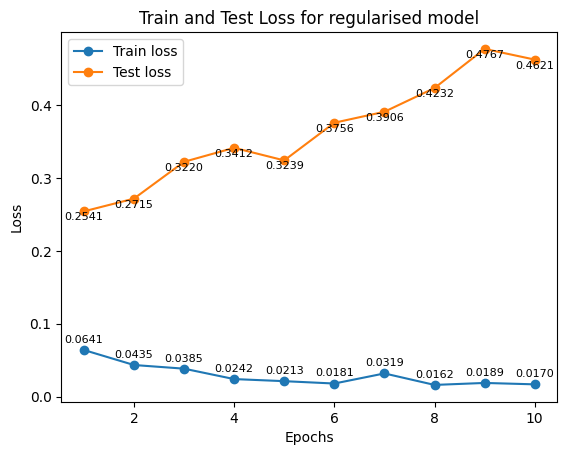

In [14]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.01}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.012})]
plotTitle = 'Train and Test Loss for regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True)

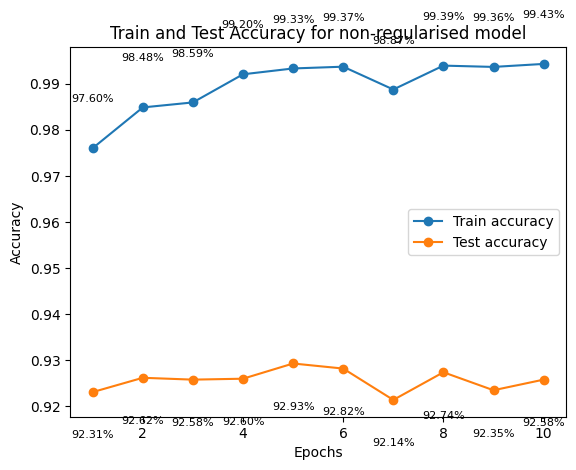

In [15]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': 0.01,
                                      'decimalPlaces': 2, 'displayPercent': True}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': -0.01,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for non-regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True)

### Task 4.2: With regularisation and data augmentation applied <font color='green'>(3 points)</font>
Train and test the same model with different regularisation techniques applied where you apply them one at a time

In [16]:
# Apply only data augmentation
# train_loader, test_loader =
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=True)

# model =
model = NetFashion(useRegularization=False).to(device)
epochs = 10 # Increasing the number of epochs by 5 since the learning will be more gradual.
# optimiser =
optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0)
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.306788  [   64/60000]
loss: 0.625032  [ 6464/60000]
loss: 0.867895  [12864/60000]
loss: 0.329923  [19264/60000]
loss: 0.463385  [25664/60000]
loss: 0.256927  [32064/60000]
loss: 0.311057  [38464/60000]
loss: 0.314349  [44864/60000]
loss: 0.201025  [51264/60000]
loss: 0.457472  [57664/60000]


Epochs:  10%|█         | 1/10 [00:47<07:10, 47.83s/it]

Train Error: 
 Accuracy: 89.4%, Avg loss: 0.290186 

Test Error: 
 Accuracy: 89.2%, Avg loss: 0.296014 

Epoch 2:

loss: 0.222823  [   64/60000]
loss: 0.245082  [ 6464/60000]
loss: 0.334538  [12864/60000]
loss: 0.400314  [19264/60000]
loss: 0.259900  [25664/60000]
loss: 0.209235  [32064/60000]
loss: 0.410990  [38464/60000]
loss: 0.271196  [44864/60000]
loss: 0.412502  [51264/60000]
loss: 0.295739  [57664/60000]


Epochs:  20%|██        | 2/10 [01:40<06:43, 50.47s/it]

Train Error: 
 Accuracy: 91.4%, Avg loss: 0.229506 

Test Error: 
 Accuracy: 91.1%, Avg loss: 0.244634 

Epoch 3:

loss: 0.294352  [   64/60000]
loss: 0.282365  [ 6464/60000]
loss: 0.105496  [12864/60000]
loss: 0.291980  [19264/60000]
loss: 0.151874  [25664/60000]
loss: 0.242212  [32064/60000]
loss: 0.146754  [38464/60000]
loss: 0.163879  [44864/60000]
loss: 0.101114  [51264/60000]
loss: 0.242915  [57664/60000]


Epochs:  30%|███       | 3/10 [02:27<05:42, 48.95s/it]

Train Error: 
 Accuracy: 91.3%, Avg loss: 0.237517 

Test Error: 
 Accuracy: 90.4%, Avg loss: 0.271638 

Epoch 4:

loss: 0.258660  [   64/60000]
loss: 0.214377  [ 6464/60000]
loss: 0.296570  [12864/60000]
loss: 0.211432  [19264/60000]
loss: 0.222808  [25664/60000]
loss: 0.150219  [32064/60000]
loss: 0.185612  [38464/60000]
loss: 0.144421  [44864/60000]
loss: 0.265606  [51264/60000]
loss: 0.366361  [57664/60000]


Epochs:  40%|████      | 4/10 [03:18<04:58, 49.74s/it]

Train Error: 
 Accuracy: 92.6%, Avg loss: 0.199506 

Test Error: 
 Accuracy: 91.9%, Avg loss: 0.226305 

Epoch 5:

loss: 0.140218  [   64/60000]
loss: 0.184654  [ 6464/60000]
loss: 0.161459  [12864/60000]
loss: 0.149739  [19264/60000]
loss: 0.155842  [25664/60000]
loss: 0.172382  [32064/60000]
loss: 0.211336  [38464/60000]
loss: 0.180052  [44864/60000]
loss: 0.216708  [51264/60000]
loss: 0.287793  [57664/60000]


Epochs:  50%|█████     | 5/10 [04:05<04:04, 48.92s/it]

Train Error: 
 Accuracy: 93.9%, Avg loss: 0.169729 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.213493 

Epoch 6:

loss: 0.139416  [   64/60000]
loss: 0.131699  [ 6464/60000]
loss: 0.123883  [12864/60000]
loss: 0.190194  [19264/60000]
loss: 0.166631  [25664/60000]
loss: 0.284301  [32064/60000]
loss: 0.216588  [38464/60000]
loss: 0.246799  [44864/60000]
loss: 0.246961  [51264/60000]
loss: 0.102855  [57664/60000]


Epochs:  60%|██████    | 6/10 [04:54<03:15, 48.92s/it]

Train Error: 
 Accuracy: 93.8%, Avg loss: 0.165426 

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.213532 

Epoch 7:

loss: 0.093884  [   64/60000]
loss: 0.149888  [ 6464/60000]
loss: 0.089805  [12864/60000]
loss: 0.182616  [19264/60000]
loss: 0.198361  [25664/60000]
loss: 0.130685  [32064/60000]
loss: 0.079464  [38464/60000]
loss: 0.223340  [44864/60000]
loss: 0.269724  [51264/60000]
loss: 0.258039  [57664/60000]


Epochs:  70%|███████   | 7/10 [05:43<02:26, 48.85s/it]

Train Error: 
 Accuracy: 94.2%, Avg loss: 0.156102 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.216710 

Epoch 8:

loss: 0.194471  [   64/60000]
loss: 0.144753  [ 6464/60000]
loss: 0.136472  [12864/60000]
loss: 0.192049  [19264/60000]
loss: 0.287203  [25664/60000]
loss: 0.109180  [32064/60000]
loss: 0.082126  [38464/60000]
loss: 0.082152  [44864/60000]
loss: 0.232681  [51264/60000]
loss: 0.074596  [57664/60000]


Epochs:  80%|████████  | 8/10 [06:33<01:38, 49.33s/it]

Train Error: 
 Accuracy: 95.1%, Avg loss: 0.133334 

Test Error: 
 Accuracy: 92.9%, Avg loss: 0.205880 

Epoch 9:

loss: 0.146722  [   64/60000]
loss: 0.089393  [ 6464/60000]
loss: 0.367662  [12864/60000]
loss: 0.103505  [19264/60000]
loss: 0.135858  [25664/60000]
loss: 0.173304  [32064/60000]
loss: 0.094647  [38464/60000]
loss: 0.122303  [44864/60000]
loss: 0.208269  [51264/60000]
loss: 0.180482  [57664/60000]


Epochs:  90%|█████████ | 9/10 [07:21<00:48, 48.78s/it]

Train Error: 
 Accuracy: 95.1%, Avg loss: 0.128929 

Test Error: 
 Accuracy: 93.2%, Avg loss: 0.211273 

Epoch 10:

loss: 0.045836  [   64/60000]
loss: 0.095429  [ 6464/60000]
loss: 0.190904  [12864/60000]
loss: 0.183462  [19264/60000]
loss: 0.126048  [25664/60000]
loss: 0.195661  [32064/60000]
loss: 0.151497  [38464/60000]
loss: 0.112605  [44864/60000]
loss: 0.407998  [51264/60000]
loss: 0.150326  [57664/60000]


Epochs: 100%|██████████| 10/10 [08:07<00:00, 48.75s/it]

Train Error: 
 Accuracy: 95.4%, Avg loss: 0.121825 

Test Error: 
 Accuracy: 93.2%, Avg loss: 0.204199 

Done training!


Plotting metrics

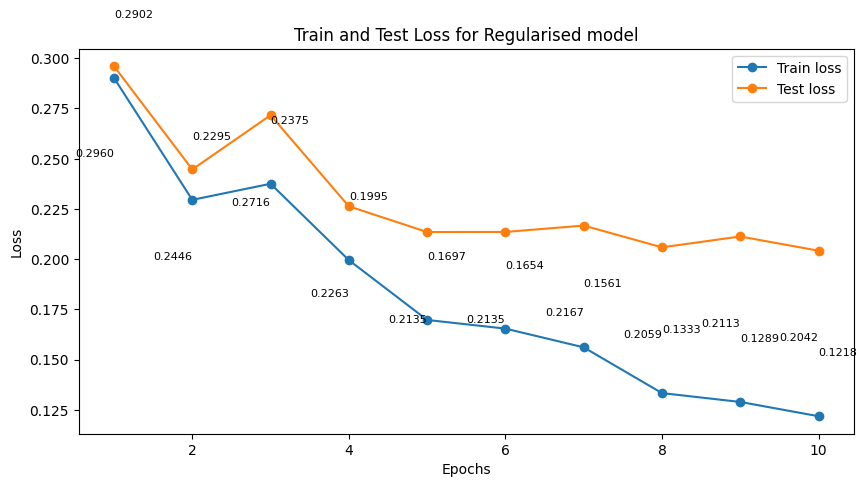

In [17]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

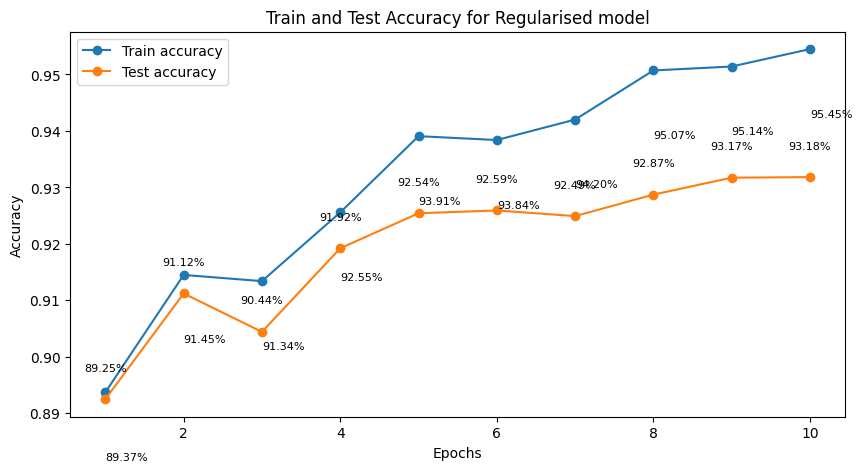

In [18]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

In [20]:
# Apply only regularisation on the cnn model
# train_loader, test_loader =
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=False)

# model =
model = NetFashion(useRegularization=True).to(device)
epochs = 10 # Increasing the number of epochs by 5 since the learning will be more gradual.
# optimiser =
optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0)

train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.306979  [   64/60000]
loss: 0.683367  [ 6464/60000]
loss: 0.391755  [12864/60000]
loss: 0.319449  [19264/60000]
loss: 0.123960  [25664/60000]
loss: 0.441778  [32064/60000]
loss: 0.172957  [38464/60000]
loss: 0.175545  [44864/60000]
loss: 0.240430  [51264/60000]
loss: 0.185658  [57664/60000]


Epochs:  10%|█         | 1/10 [00:31<04:45, 31.67s/it]

Train Error: 
 Accuracy: 91.4%, Avg loss: 0.232561 

Test Error: 
 Accuracy: 90.0%, Avg loss: 0.272332 

Epoch 2:

loss: 0.331858  [   64/60000]
loss: 0.178991  [ 6464/60000]
loss: 0.218196  [12864/60000]
loss: 0.258421  [19264/60000]
loss: 0.262621  [25664/60000]
loss: 0.250611  [32064/60000]
loss: 0.258657  [38464/60000]
loss: 0.239643  [44864/60000]
loss: 0.497422  [51264/60000]
loss: 0.161385  [57664/60000]


Epochs:  20%|██        | 2/10 [01:02<04:11, 31.38s/it]

Train Error: 
 Accuracy: 93.4%, Avg loss: 0.180881 

Test Error: 
 Accuracy: 91.6%, Avg loss: 0.233701 

Epoch 3:

loss: 0.215595  [   64/60000]
loss: 0.062964  [ 6464/60000]
loss: 0.104027  [12864/60000]
loss: 0.183375  [19264/60000]
loss: 0.187466  [25664/60000]
loss: 0.187073  [32064/60000]
loss: 0.201581  [38464/60000]
loss: 0.043185  [44864/60000]
loss: 0.114257  [51264/60000]
loss: 0.101177  [57664/60000]


Epochs:  30%|███       | 3/10 [01:34<03:40, 31.56s/it]

Train Error: 
 Accuracy: 95.1%, Avg loss: 0.132573 

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.219153 

Epoch 4:

loss: 0.081077  [   64/60000]
loss: 0.273438  [ 6464/60000]
loss: 0.174810  [12864/60000]
loss: 0.136881  [19264/60000]
loss: 0.154102  [25664/60000]
loss: 0.111038  [32064/60000]
loss: 0.064399  [38464/60000]
loss: 0.183031  [44864/60000]
loss: 0.284422  [51264/60000]
loss: 0.220263  [57664/60000]


Epochs:  40%|████      | 4/10 [02:05<03:08, 31.34s/it]

Train Error: 
 Accuracy: 96.3%, Avg loss: 0.107689 

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.211907 

Epoch 5:

loss: 0.193474  [   64/60000]
loss: 0.069930  [ 6464/60000]
loss: 0.172476  [12864/60000]
loss: 0.065579  [19264/60000]
loss: 0.070372  [25664/60000]
loss: 0.204874  [32064/60000]
loss: 0.043240  [38464/60000]
loss: 0.013651  [44864/60000]
loss: 0.080682  [51264/60000]
loss: 0.067156  [57664/60000]


Epochs:  50%|█████     | 5/10 [02:37<02:37, 31.43s/it]

Train Error: 
 Accuracy: 97.3%, Avg loss: 0.078452 

Test Error: 
 Accuracy: 92.8%, Avg loss: 0.214637 

Epoch 6:

loss: 0.045505  [   64/60000]
loss: 0.030202  [ 6464/60000]
loss: 0.111438  [12864/60000]
loss: 0.032331  [19264/60000]
loss: 0.078697  [25664/60000]
loss: 0.245613  [32064/60000]
loss: 0.030193  [38464/60000]
loss: 0.168419  [44864/60000]
loss: 0.035649  [51264/60000]
loss: 0.078979  [57664/60000]


Epochs:  60%|██████    | 6/10 [03:08<02:05, 31.40s/it]

Train Error: 
 Accuracy: 98.2%, Avg loss: 0.051841 

Test Error: 
 Accuracy: 92.9%, Avg loss: 0.236549 

Epoch 7:

loss: 0.078084  [   64/60000]
loss: 0.079403  [ 6464/60000]
loss: 0.009210  [12864/60000]
loss: 0.047924  [19264/60000]
loss: 0.010195  [25664/60000]
loss: 0.108256  [32064/60000]
loss: 0.016142  [38464/60000]
loss: 0.081740  [44864/60000]
loss: 0.043797  [51264/60000]
loss: 0.033473  [57664/60000]


Epochs:  70%|███████   | 7/10 [03:40<01:35, 31.73s/it]

Train Error: 
 Accuracy: 98.4%, Avg loss: 0.045661 

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.280032 

Epoch 8:

loss: 0.070179  [   64/60000]
loss: 0.009816  [ 6464/60000]
loss: 0.006028  [12864/60000]
loss: 0.004942  [19264/60000]
loss: 0.009995  [25664/60000]
loss: 0.037723  [32064/60000]
loss: 0.098229  [38464/60000]
loss: 0.106408  [44864/60000]
loss: 0.125652  [51264/60000]
loss: 0.054208  [57664/60000]


Epochs:  80%|████████  | 8/10 [04:13<01:04, 32.12s/it]

Train Error: 
 Accuracy: 99.1%, Avg loss: 0.029057 

Test Error: 
 Accuracy: 92.9%, Avg loss: 0.262507 

Epoch 9:

loss: 0.098802  [   64/60000]
loss: 0.005480  [ 6464/60000]
loss: 0.019198  [12864/60000]
loss: 0.108997  [19264/60000]
loss: 0.077974  [25664/60000]
loss: 0.005313  [32064/60000]
loss: 0.005557  [38464/60000]
loss: 0.030702  [44864/60000]
loss: 0.033795  [51264/60000]
loss: 0.055171  [57664/60000]


Epochs:  90%|█████████ | 9/10 [04:44<00:31, 31.78s/it]

Train Error: 
 Accuracy: 99.0%, Avg loss: 0.030000 

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.320368 

Epoch 10:

loss: 0.059496  [   64/60000]
loss: 0.020893  [ 6464/60000]
loss: 0.028620  [12864/60000]
loss: 0.025635  [19264/60000]
loss: 0.053922  [25664/60000]
loss: 0.002746  [32064/60000]
loss: 0.078069  [38464/60000]
loss: 0.010726  [44864/60000]
loss: 0.036762  [51264/60000]
loss: 0.015853  [57664/60000]


Epochs: 100%|██████████| 10/10 [05:16<00:00, 31.64s/it]

Train Error: 
 Accuracy: 99.1%, Avg loss: 0.027260 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.358557 

Done training!


Plotting metrics

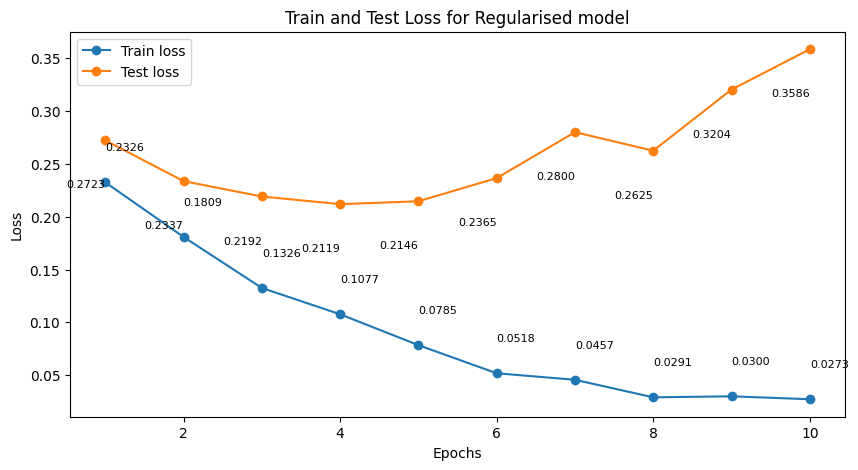

In [21]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

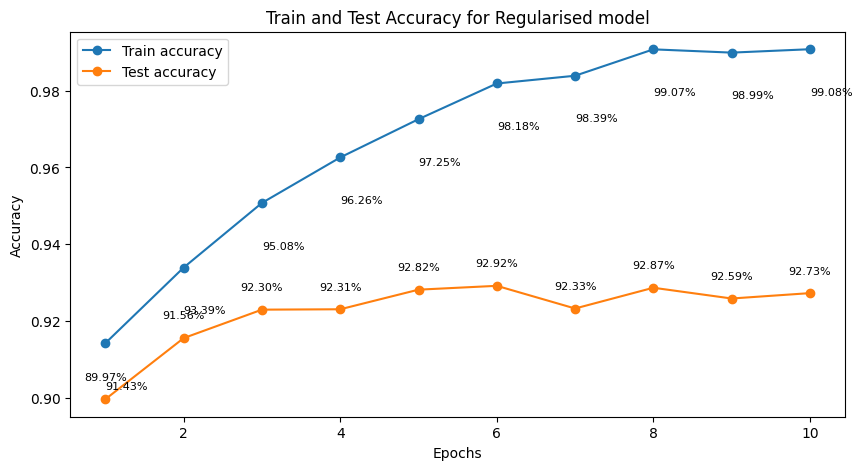

In [22]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

In [24]:
# Apply only weight decay technique
# train_loader, test_loader =
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=False)

# model =
model = NetFashion(useRegularization=False).to(device)
epochs = 10 # Increasing the number of epochs by 5 since the learning will be more gradual.
# optimiser =
optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.307578  [   64/60000]
loss: 0.439622  [ 6464/60000]
loss: 0.502414  [12864/60000]
loss: 0.471608  [19264/60000]
loss: 0.565193  [25664/60000]
loss: 0.319191  [32064/60000]
loss: 0.471552  [38464/60000]
loss: 0.388473  [44864/60000]
loss: 0.286039  [51264/60000]
loss: 0.293039  [57664/60000]


Epochs:  10%|█         | 1/10 [00:31<04:44, 31.65s/it]

Train Error: 
 Accuracy: 92.0%, Avg loss: 0.220407 

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.252908 

Epoch 2:

loss: 0.188272  [   64/60000]
loss: 0.273992  [ 6464/60000]
loss: 0.130780  [12864/60000]
loss: 0.252721  [19264/60000]
loss: 0.269328  [25664/60000]
loss: 0.262599  [32064/60000]
loss: 0.176463  [38464/60000]
loss: 0.136843  [44864/60000]
loss: 0.166131  [51264/60000]
loss: 0.169111  [57664/60000]


Epochs:  20%|██        | 2/10 [01:02<04:10, 31.28s/it]

Train Error: 
 Accuracy: 93.3%, Avg loss: 0.184263 

Test Error: 
 Accuracy: 91.3%, Avg loss: 0.237877 

Epoch 3:

loss: 0.169751  [   64/60000]
loss: 0.145987  [ 6464/60000]
loss: 0.033857  [12864/60000]
loss: 0.113746  [19264/60000]
loss: 0.127382  [25664/60000]
loss: 0.226991  [32064/60000]
loss: 0.071428  [38464/60000]
loss: 0.198240  [44864/60000]
loss: 0.314525  [51264/60000]
loss: 0.108303  [57664/60000]


Epochs:  30%|███       | 3/10 [01:34<03:41, 31.66s/it]

Train Error: 
 Accuracy: 95.1%, Avg loss: 0.136535 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.211600 

Epoch 4:

loss: 0.250725  [   64/60000]
loss: 0.179996  [ 6464/60000]
loss: 0.101407  [12864/60000]
loss: 0.093725  [19264/60000]
loss: 0.059743  [25664/60000]
loss: 0.107237  [32064/60000]
loss: 0.128859  [38464/60000]
loss: 0.216148  [44864/60000]
loss: 0.157330  [51264/60000]
loss: 0.151475  [57664/60000]


Epochs:  40%|████      | 4/10 [02:05<03:08, 31.48s/it]

Train Error: 
 Accuracy: 95.6%, Avg loss: 0.122727 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.209666 

Epoch 5:

loss: 0.127046  [   64/60000]
loss: 0.190901  [ 6464/60000]
loss: 0.118404  [12864/60000]
loss: 0.102489  [19264/60000]
loss: 0.158894  [25664/60000]
loss: 0.065172  [32064/60000]
loss: 0.161426  [38464/60000]
loss: 0.155853  [44864/60000]
loss: 0.134740  [51264/60000]
loss: 0.319304  [57664/60000]


Epochs:  50%|█████     | 5/10 [02:37<02:36, 31.37s/it]

Train Error: 
 Accuracy: 96.3%, Avg loss: 0.097178 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.219316 

Epoch 6:

loss: 0.055341  [   64/60000]
loss: 0.122152  [ 6464/60000]
loss: 0.044295  [12864/60000]
loss: 0.052664  [19264/60000]
loss: 0.073458  [25664/60000]
loss: 0.251000  [32064/60000]
loss: 0.092851  [38464/60000]
loss: 0.156056  [44864/60000]
loss: 0.049458  [51264/60000]
loss: 0.115559  [57664/60000]


Epochs:  60%|██████    | 6/10 [03:08<02:05, 31.39s/it]

Train Error: 
 Accuracy: 96.9%, Avg loss: 0.083711 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.212964 

Epoch 7:

loss: 0.060841  [   64/60000]
loss: 0.076381  [ 6464/60000]
loss: 0.211574  [12864/60000]
loss: 0.108614  [19264/60000]
loss: 0.145070  [25664/60000]
loss: 0.046621  [32064/60000]
loss: 0.135266  [38464/60000]
loss: 0.110693  [44864/60000]
loss: 0.136782  [51264/60000]
loss: 0.069827  [57664/60000]


Epochs:  70%|███████   | 7/10 [03:39<01:33, 31.27s/it]

Train Error: 
 Accuracy: 97.5%, Avg loss: 0.071993 

Test Error: 
 Accuracy: 93.1%, Avg loss: 0.222470 

Epoch 8:

loss: 0.064957  [   64/60000]
loss: 0.034648  [ 6464/60000]
loss: 0.108766  [12864/60000]
loss: 0.037699  [19264/60000]
loss: 0.008359  [25664/60000]
loss: 0.053022  [32064/60000]
loss: 0.093164  [38464/60000]
loss: 0.088464  [44864/60000]
loss: 0.024626  [51264/60000]
loss: 0.074633  [57664/60000]


Epochs:  80%|████████  | 8/10 [04:11<01:02, 31.45s/it]

Train Error: 
 Accuracy: 97.6%, Avg loss: 0.065522 

Test Error: 
 Accuracy: 92.2%, Avg loss: 0.245203 

Epoch 9:

loss: 0.059743  [   64/60000]
loss: 0.041192  [ 6464/60000]
loss: 0.058024  [12864/60000]
loss: 0.073040  [19264/60000]
loss: 0.060412  [25664/60000]
loss: 0.029460  [32064/60000]
loss: 0.154032  [38464/60000]
loss: 0.075137  [44864/60000]
loss: 0.145223  [51264/60000]
loss: 0.059129  [57664/60000]


Epochs:  90%|█████████ | 9/10 [04:45<00:32, 32.13s/it]

Train Error: 
 Accuracy: 98.0%, Avg loss: 0.058644 

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.248086 

Epoch 10:

loss: 0.024595  [   64/60000]
loss: 0.010456  [ 6464/60000]
loss: 0.092844  [12864/60000]
loss: 0.060600  [19264/60000]
loss: 0.069742  [25664/60000]
loss: 0.011344  [32064/60000]
loss: 0.003707  [38464/60000]
loss: 0.101624  [44864/60000]
loss: 0.073819  [51264/60000]
loss: 0.065779  [57664/60000]


Epochs: 100%|██████████| 10/10 [05:16<00:00, 31.67s/it]

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.043297 

Test Error: 
 Accuracy: 92.9%, Avg loss: 0.250314 

Done training!


Plotting metrics

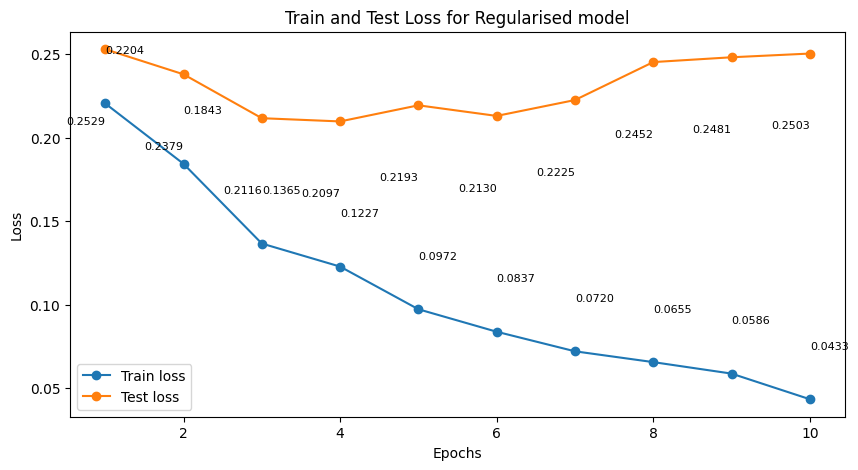

In [25]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

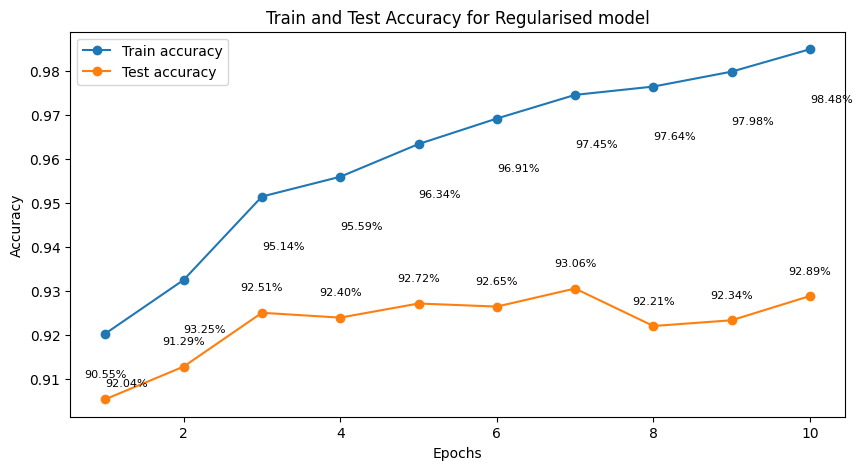

In [26]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

Apply all the regularisation techniques together below

In [27]:
# Apply all regularisation techniques
# train_loader, test_loader =
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=True)
# model =
model = NetFashion(useRegularization=True).to(device)
epochs = 10 # Increasing the number of epochs by 5 since the learning will be more gradual.
# optimiser =
optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.302572  [   64/60000]
loss: 0.499522  [ 6464/60000]
loss: 0.467758  [12864/60000]
loss: 0.542644  [19264/60000]
loss: 0.580298  [25664/60000]
loss: 0.397476  [32064/60000]
loss: 0.303684  [38464/60000]
loss: 0.395386  [44864/60000]
loss: 0.446132  [51264/60000]
loss: 0.321427  [57664/60000]


Epochs:  10%|█         | 1/10 [00:48<07:14, 48.32s/it]

Train Error: 
 Accuracy: 80.8%, Avg loss: 0.514607 

Test Error: 
 Accuracy: 81.0%, Avg loss: 0.508931 

Epoch 2:

loss: 0.623434  [   64/60000]
loss: 0.505535  [ 6464/60000]
loss: 0.434096  [12864/60000]
loss: 0.697152  [19264/60000]
loss: 0.428981  [25664/60000]
loss: 0.474748  [32064/60000]
loss: 0.462742  [38464/60000]
loss: 0.333895  [44864/60000]
loss: 0.461058  [51264/60000]
loss: 0.423502  [57664/60000]


Epochs:  20%|██        | 2/10 [01:36<06:24, 48.03s/it]

Train Error: 
 Accuracy: 82.1%, Avg loss: 0.483705 

Test Error: 
 Accuracy: 82.8%, Avg loss: 0.484648 

Epoch 3:

loss: 0.503745  [   64/60000]
loss: 0.598667  [ 6464/60000]
loss: 0.575483  [12864/60000]
loss: 0.306176  [19264/60000]
loss: 0.474211  [25664/60000]
loss: 0.318781  [32064/60000]
loss: 0.481511  [38464/60000]
loss: 0.340405  [44864/60000]
loss: 0.308825  [51264/60000]
loss: 0.415941  [57664/60000]


Epochs:  30%|███       | 3/10 [02:24<05:36, 48.06s/it]

Train Error: 
 Accuracy: 85.6%, Avg loss: 0.394896 

Test Error: 
 Accuracy: 85.8%, Avg loss: 0.393615 

Epoch 4:

loss: 0.352825  [   64/60000]
loss: 0.539379  [ 6464/60000]
loss: 0.295932  [12864/60000]
loss: 0.379542  [19264/60000]
loss: 0.476421  [25664/60000]
loss: 0.708539  [32064/60000]
loss: 0.436737  [38464/60000]
loss: 0.193148  [44864/60000]
loss: 0.319045  [51264/60000]
loss: 0.262504  [57664/60000]


Epochs:  40%|████      | 4/10 [03:12<04:48, 48.00s/it]

Train Error: 
 Accuracy: 85.0%, Avg loss: 0.401585 

Test Error: 
 Accuracy: 85.0%, Avg loss: 0.403817 

Epoch 5:

loss: 0.593015  [   64/60000]
loss: 0.381590  [ 6464/60000]
loss: 0.443137  [12864/60000]
loss: 0.405961  [19264/60000]
loss: 0.341821  [25664/60000]
loss: 0.280162  [32064/60000]
loss: 0.674779  [38464/60000]
loss: 0.478489  [44864/60000]
loss: 0.458573  [51264/60000]
loss: 0.199408  [57664/60000]


Epochs:  50%|█████     | 5/10 [04:00<04:00, 48.05s/it]

Train Error: 
 Accuracy: 86.1%, Avg loss: 0.379046 

Test Error: 
 Accuracy: 85.8%, Avg loss: 0.375773 

Epoch 6:

loss: 0.293485  [   64/60000]
loss: 0.593121  [ 6464/60000]
loss: 0.431124  [12864/60000]
loss: 0.605438  [19264/60000]
loss: 0.389834  [25664/60000]
loss: 0.523205  [32064/60000]
loss: 0.272123  [38464/60000]
loss: 0.303249  [44864/60000]
loss: 0.448230  [51264/60000]
loss: 0.443026  [57664/60000]


Epochs:  60%|██████    | 6/10 [04:48<03:12, 48.22s/it]

Train Error: 
 Accuracy: 85.7%, Avg loss: 0.391370 

Test Error: 
 Accuracy: 85.5%, Avg loss: 0.391984 

Epoch 7:

loss: 0.535863  [   64/60000]
loss: 0.358725  [ 6464/60000]
loss: 0.338756  [12864/60000]
loss: 0.450207  [19264/60000]
loss: 0.281453  [25664/60000]
loss: 0.360520  [32064/60000]
loss: 0.435287  [38464/60000]
loss: 0.255835  [44864/60000]
loss: 0.351675  [51264/60000]
loss: 0.349382  [57664/60000]


Epochs:  70%|███████   | 7/10 [05:37<02:24, 48.24s/it]

Train Error: 
 Accuracy: 85.8%, Avg loss: 0.382159 

Test Error: 
 Accuracy: 85.6%, Avg loss: 0.382817 

Epoch 8:

loss: 0.281386  [   64/60000]
loss: 0.469680  [ 6464/60000]
loss: 0.277019  [12864/60000]
loss: 0.371317  [19264/60000]
loss: 0.287583  [25664/60000]
loss: 0.322702  [32064/60000]
loss: 0.268076  [38464/60000]
loss: 0.219662  [44864/60000]
loss: 0.387174  [51264/60000]
loss: 0.298749  [57664/60000]


Epochs:  80%|████████  | 8/10 [06:25<01:36, 48.16s/it]

Train Error: 
 Accuracy: 86.3%, Avg loss: 0.369899 

Test Error: 
 Accuracy: 86.1%, Avg loss: 0.368514 

Epoch 9:

loss: 0.625684  [   64/60000]
loss: 0.361327  [ 6464/60000]
loss: 0.411656  [12864/60000]
loss: 0.454622  [19264/60000]
loss: 0.375797  [25664/60000]
loss: 0.438272  [32064/60000]
loss: 0.419326  [38464/60000]
loss: 0.243774  [44864/60000]
loss: 0.453501  [51264/60000]
loss: 0.238930  [57664/60000]


Epochs:  90%|█████████ | 9/10 [07:12<00:47, 47.99s/it]

Train Error: 
 Accuracy: 84.7%, Avg loss: 0.407727 

Test Error: 
 Accuracy: 85.4%, Avg loss: 0.390641 

Epoch 10:

loss: 0.484164  [   64/60000]
loss: 0.333311  [ 6464/60000]
loss: 0.315686  [12864/60000]
loss: 0.485015  [19264/60000]
loss: 0.324069  [25664/60000]
loss: 0.292500  [32064/60000]
loss: 0.422608  [38464/60000]
loss: 0.456718  [44864/60000]
loss: 0.424571  [51264/60000]
loss: 0.434107  [57664/60000]


Epochs: 100%|██████████| 10/10 [08:00<00:00, 48.05s/it]

Train Error: 
 Accuracy: 86.9%, Avg loss: 0.353874 

Test Error: 
 Accuracy: 87.2%, Avg loss: 0.355090 

Done training!


Plotting metrics

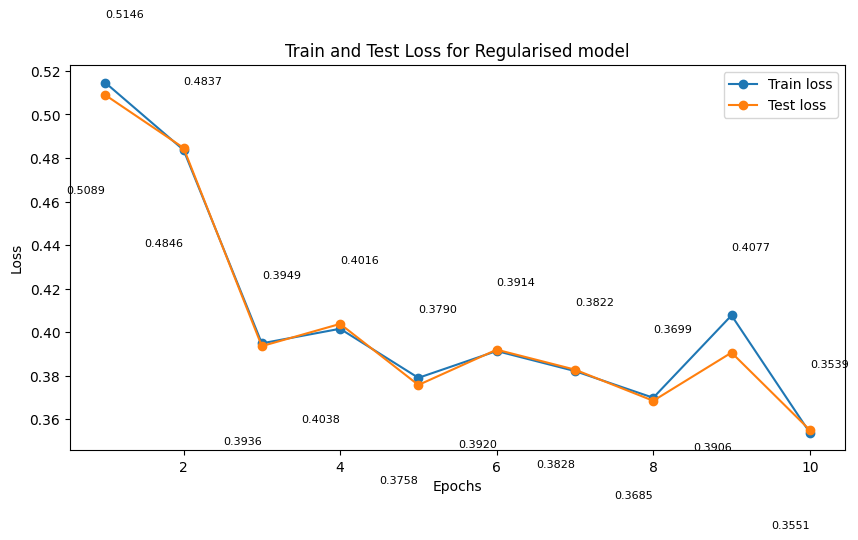

In [28]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

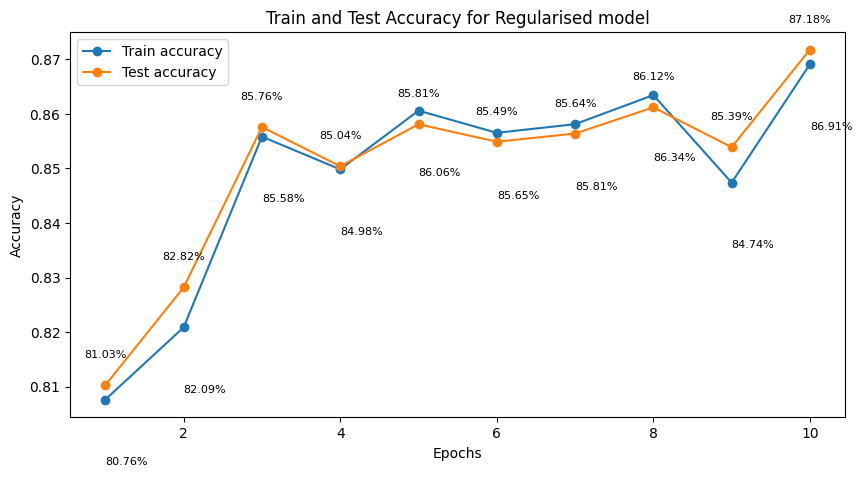

In [29]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

## Reflection <font color='green'>(1 point)</font>
Write your thoughts and observations about overfitting and the techniques used above to reduce them in brief.

<font color='red'>Overfitting happens when a model memorizes training data instead of learning general patterns, leading to poor performance on new data. To tackle this, we used:
<font color='red'>
Data Augmentation (random flips/rotations) to make the model more adaptable.
Dropout prevents reliance on specific “co-adapted” subsets of neurons.
Weight Decay (L2 Regularization) to keep weights in check and avoid overfitting.

Using all three together improved generalization, but tuning them properly was key. Regularization helps, but too much can hurt learning, finding the right balance is important </font>

